In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note : Use the drive link for the processed dataset

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import face_recognition

In [ ]:
!python --version
print(torch.__version__)

Python 3.6.9
1.7.0+cu101


In [ ]:
!pip3 install face_recognition

In [ ]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random
video_files =  glob.glob('Path/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('Path/Celeb_real_face_only/*.mp4')
video_files += glob.glob('Path/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('Path/DFDC_REAL_Face_only_data/*.mp4')
video_files += glob.glob('Path/FF_Face_only_data/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
print(len(video_files))
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

6450
frames are  [148, 148, 148, 148, 148, 148, 124, 148, 144, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 148, 148, 147, 148, 148, 148, 118, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 143, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 134, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 144, 148, 148, 148, 148, 148, 14

In [ ]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('Path_of_CSV',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    #print('temp :',temp_video)
    #print('Labels ::::', labels)
    #print('1st lab_file:', lab["file"])
    #print('2nd lab.loc:', lab["file"] == temp_video)
    #print('3rd lab.iloc:', lab.iloc[(lab.loc[lab["file"] == temp_video].index.values[0]),1])
    label = lab.iloc[(lab.loc[lab["file"] == temp_video].index.values[0]),1]
    #print('Label', label)
    
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake


def count_real_fake(csv_path):
  
  import tqdm

  header_list = ["file","label"]
  df = pd.read_csv(csv_path, names=header_list)
  print(df)
  count_real = 0
  count_fake = 0
  for index, row in tqdm.tqdm(df.iterrows()):
    if row['label'] == 'REAL':
      count_real += 1
    elif row['label'] == 'FAKE':
      count_fake += 1
  return count_real, count_fake


train :  5141
train :  1286
TRAIN:  Real: 2628  Fake: 2513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Valid:  Real: 673  Fake: 613
918.mp4
length: 60 label 1


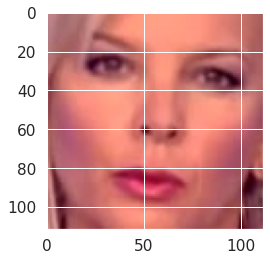

In [ ]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split









header_list = ["file","label"]
labels = pd.read_csv('Path_of_CSV',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
#valid_videos = train_videos[int(0.8*len(video_files)):]
# print(train_videos)
# print(valid_videos)
#test_videos = video_files[int(0.8*len(video_files)):]
# print(test_videos)

print("train : " , len(train_videos))
print("train : " , len(valid_videos))
#print("test : " , len(test_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("Valid: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])
#print("TEST: ", "Real:",number_of_real_and_fake_videos(test_videos)[0]," Fake:",number_of_real_and_fake_videos(test_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 60,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 60,transform = train_transforms)

#test_data = video_dataset(test_videos,labels,sequence_length = 80,transform = train_transforms)

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
#for i, (input, targets) in enumerate(train_loader):
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
#test_loader = DataLoader(test_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])









In [ ]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.summary
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'Path_to_save')
    # torch.save({
    #         'epoch': num_epochs,
    #         'model_state_dict':model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': lr,
    #         }, '/content/drive/MyDrive/Hammad/Deepfake_detection_using_deep_learning-master/checkpoint100aaaaanew.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

Streaming output truncated to the last 5000 lines.
blnmxntbey.mp4
length: 60 label 1
bivdbsqzbq.mp4
length: 60 label 0
295.mp4
length: 60 label 1
[Epoch 30/30] [Batch 973 / 1286] [Loss: 0.144659, Acc: 90.43%]id40_0000.mp4
length: 60 label 1
id57_id55_0007.mp4
length: 60 label 0
bcfzwkyukw.mp4
length: 60 label 0
wfihvsniyz.mp4
[Epoch 30/30] [Batch 974 / 1286] [Loss: 0.144691, Acc: 90.41%]length: 60 label 1
vtfzsqhfxt.mp4
length: 60 label 1
id11_0006.mp4
length: 60 label 1
849_771.mp4
length: 60 label 0
519_515.mp4
length: 60 label 0
[Epoch 30/30] [Batch 975 / 1286] [Loss: 0.144720, Acc: 90.42%]kpltzztlvj.mp4
length: 60 label 1
nduwcnqkvy.mp4
length: 60 label 1
205_184.mp4
length: 60 label 0
aykawoglaw.mp4
length: 60 label 0
[Epoch 30/30] [Batch 976 / 1286] [Loss: 0.144572, Acc: 90.43%]dmafzlffwj.mp4
length: 60 label 0
698_693.mp4
length: 60 label 0
id54_id49_0004.mp4
length: 60 label 0
550_452.mp4
[Epoch 30/30] [Batch 977 / 1286] [Loss: 0.144957, Acc: 90.39%]length: 60 label 0
id51_id55

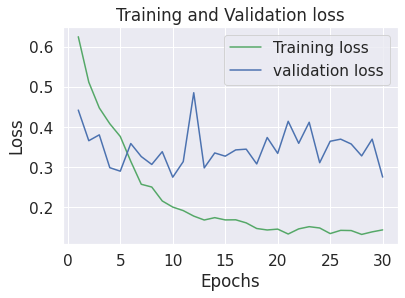

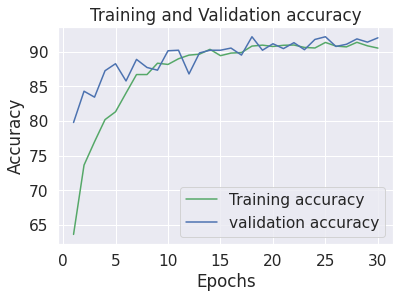

[[563  50]
 [ 53 620]]
True positive =  563
False positive =  50
False negative =  53
True negative =  620




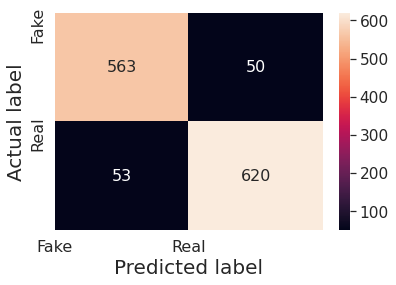

Calculated Accuracy 91.99066874027993


In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.00001
#number of epochs 
num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

# TODO
# PATH="Path_to_load"
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# num_epochs = checkpoint['epoch']
# lr = checkpoint['loss']
# model.train()

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)